# Electron MVA Tutorial

## Introduction

Imagine you are tasked with retraining the multivariate electron identification algorithm in CMS (aka. the Electron MVA) for the upcoming Run 3. How would you tackle that?

This tutorial explains you exactly how it was done in Run 2, so you could continue where we left off and improve from there.

In general, there are 3 stages you need to work through in this endevor, which all require different skills and tools:

1. **Extract electron data** from CMS simulated events (MC). This step is also known as "producing ntuples".

2. **Train a multivariate classifier**. Traditionally we train here Boosted Decision Trees (BDTs).
   
3. **Implement the classifier in back in CMSSW**. This step is either a straight forward copy-and-paste job if you stick with the BDT algorithm, or involves a lot of C++ programming when you choose to take another one.
   
Here, we will tell you how to use the "ElectronMVANtuplizer" in CMSSW to create the ntuples for the training and how to train the Electron MVA with Python tools.

## Creating the Electron MVA Ntuple

### 1. Check out CMSSW environment

Make sure you initialized your grid proxy. This time we go with a brand new CMSSW release as we deal with Run 3 samples:

```Bash
cmsrel CMSSW_10_6_3
cd CMSSW_10_6_3/src
cmsenv
git cms-addpkg RecoEgamma/ElectronIdentification
```

Wait for the checkout to complete and then change into the directory `RecoEgamma/ElectronIdentification/test`. There you find the configuration file for the ElectronMVANtuplizer, named `TestElectronMVA_cfg.py`.

### 2. Change input files to new Run 3 samples

The Electron MVA should separate prompt electrons from fakes that come from no particular hard process. That's why we will use a **Drell-Yan plus jets** (DY+jets) sample for the training.

Signal (or the positive class in ML language) will be reconstructed electrons that match to a true prompt electron, while the background (or the negative class) will be all unmatched and non-prompt electrons (e.g. electrons in jets). We will ignore electrons from tau decays. All this categorization is done in the ElectronMVANtuplizer.

This is the name of the MC DY+jets sample we will use:
```
/DYJets_incl_MLL-50_TuneCP5_14TeV-madgraphMLM-pythia8/Run3Summer19MiniAOD-2023Scenario_106X_mcRun3_2023_realistic_v3-v1/MINIAODSIM
```

Are you familiar with the `dasgoclient`? You can check the last example you get with `dasgoclient --help` to learn how to find files within a given sample. Please find the path to some file in the DY+jets Run 3 sample and edit `process.source` in `testElectronMVA_cfg.py` to use the new file path.

You might also want to change `process.maxEvents` in the same file to a relatively small number (like 1000 events) to make a test run. Once you know it works, you set it back to `-1`, which means all events in the file.

If it does not work, try a different file in the dataset. The production of the dataset is not finished yet, so you might get unlucky and pick a file that does not exists.

### 3. Run the Ntuplizer

All that is left to do now to produce the ntuple is to issue this command in `RecoEgamma/ElectronIdentification/test`:
    
```Bash
cmsRun testElectronMVA_cfg.py
```

Watch the events fly by. In the end, you will have a new file called `electron_ntuple.root` in the test directory.

## Electron MVA Ntuple Data

In [28]:
import getpass
import os
username = "rembserj"
if os.system('klist | grep Default | grep ' + username + '@CERN.CH'):
    os.system('echo %s' % getpass.getpass() + " | kinit " + username)

········


The uproot library is by far the most convinient library to load data from ROOT trees into pandas DataFrames or numpy arrays, which are the most common data structures in the scientific and ML Python ecosystem.

In [2]:
import uproot
import glob

In [3]:
ls /eos/user/r/rembserj/ntuples/electron_mva_run3

electron_ntuple_000041.root  electron_ntuple_000049.root
electron_ntuple_000042.root  electron_ntuple_000050.root
electron_ntuple_000043.root  electron_ntuple_000051.root
electron_ntuple_000044.root  electron_ntuple_000052.root
electron_ntuple_000045.root  electron_ntuple_000079.root
electron_ntuple_000046.root  electron_ntuple_000090.root
electron_ntuple_000047.root  electron_ntuple_000100.root
electron_ntuple_000048.root


In [4]:
root_files = glob.glob("/eos/user/r/rembserj/ntuples/electron_mva_run3/*.root")

Load the rootfile you produced before and get the ROOT file directory structure by callling `allkeys`:

In [5]:
f = uproot.open(root_files[0])
f.allkeys()

['ntuplizer;1', 'ntuplizer/tree;1']

In [6]:
!pip install --user tqdm

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.


There we go, the TTree with the electron data we seek must be `ntuplizer/tree`! Like in C++ ROOT, ignore the semicolon and the numbers after it in the names.

In [7]:
import pandas as pd
from tqdm import tqdm

In [8]:
unneccesary_columns = ['ele_index',
       'Spring16GPV1Vals', 'Spring16GPV1RawVals', 'Spring16HZZV1Vals',
       'Spring16HZZV1RawVals', 'Fall17NoIsoV2Vals',
       'Fall17IsoV2Vals', 'Fall17IsoV1Vals',
       'Fall17NoIsoV1Vals', 'Spring16GPV1wp80', 'Spring16GPV1wp90',
       'Spring16HZZV1wpLoose', 'Fall17noIsoV2wp80', 'Fall17noIsoV2wpLoose',
       'Fall17noIsoV2wp90', 'Fall17isoV2wpHZZ', 'Fall17isoV2wp80',
       'Fall17isoV2wpLoose', 'Fall17isoV2wp90', 'Fall17noIsoV1wp90',
       'Fall17noIsoV1wp80', 'Fall17noIsoV1wpLoose', 'Fall17isoV1wp90',
       'Fall17isoV1wp80', 'Fall17isoV1wpLoose', 'nEvent', 'nRun', 'nLumi']

def get_df(root_file_name):
    df = uproot.open(root_file_name)["ntuplizer/tree"].pandas.df()
    return df.drop(unneccesary_columns, axis=1)

df = pd.concat((get_df(f) for f in  tqdm(root_files)), ignore_index=True)

100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


Let's check what columns we have in this data (or "branches" if you come from ROOT):

In [9]:
df.columns

Index([u'genNpu', u'vtxN', u'ele_q', u'ele_3q', u'matchedToGenEle', u'rho',
       u'ele_pt', u'ele_oldsigmaietaieta', u'ele_oldsigmaiphiiphi',
       u'ele_oldcircularity', u'ele_oldr9', u'ele_scletawidth',
       u'ele_sclphiwidth', u'ele_hadronicOverEm', u'ele_oldhe', u'ele_kfhits',
       u'ele_kfchi2', u'ele_gsfchi2', u'ele_fbrem', u'ele_gsfhits',
       u'ele_expected_inner_hits', u'ele_conversionVertexFitProbability',
       u'ele_ep', u'ele_eelepout', u'ele_IoEmIop', u'ele_deltaetain',
       u'ele_deltaphiin', u'ele_deltaetaseed', u'ele_psEoverEraw',
       u'ele_pfPhotonIso', u'ele_pfChargedHadIso', u'ele_pfNeutralHadIso',
       u'scl_E', u'scl_Et', u'scl_eta', u'scl_phi', u'ele_sclRawE',
       u'ele_sclNclus', u'ele_olde15', u'ele_olde25max', u'ele_olde55',
       u'ele_ecalE', u'ele_ecalErr', u'ele_trackErr', u'ele_combErr',
       u'ele_PFcombErr', u'ele_pfSumPUIso', u'ele_SCfbrem', u'ele_eClass',
       u'ele_nbrem', u'ele_oldhebc', u'ele_hebc', u'ele_isEB', u'ele_isEE'

That's a lot of information! Let's not try to understand everything at one, but explain when needed.

## Categorizing Electrons as Signal or Background

To say it once more: signal will be reconstructed electrons that match to a true prompt electron, while the background will be all unmatched and non-prompt electrons. Electrons from tau decays should be ignored.

The electron ntuplizer stores the category to which the electron belongs in the `matchedToGenEle` branch, and you can check the [ntuplizer source code](https://github.com/cms-sw/cmssw/blob/master/RecoEgamma/ElectronIdentification/plugins/ElectronMVANtuplizer.cc#L139) to learn which number corresponds to which category (starting from `UNMATCHED = 0`).

The electrons from taus correspond to `matchedToGenEle = 2`, so let's drop them from the data frame.

In [10]:
df = df[df["matchedToGenEle"] != 2]

Also we don't care about the distinction between non-prompt and unmatched electrons, so let's set both categories to the value zeros.

In [11]:
df.loc[df["matchedToGenEle"] != 1, "matchedToGenEle"] = 0

Very good, now `matchedToGenEle = 1` corresponds to signal and `matchedToGenEle = 0` to background.

In [12]:
df = df[df["scl_eta"].abs() < 2.5]

Let's take a look at the $p_T$ and $\eta$ distributions to see if they look as expected:

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def get_label(name):
    if name == 0:
        return "background"
    else:
        return "signal"

def plot_electrons(df, column, bins, logscale=False, ax=None, title=None):
    if ax is None:
        ax = plt.gca()
    for name, group in df.groupby("matchedToGenEle"):
        group[column].hist(bins=bins, histtype="step", label=get_label(name), ax=ax, density=True)
    ax.set_ylabel("density")
    ax.set_xlabel(column)
    ax.legend()
    ax.set_title(title)
    if logscale:
        ax.set_yscale("log", nonposy='clip')

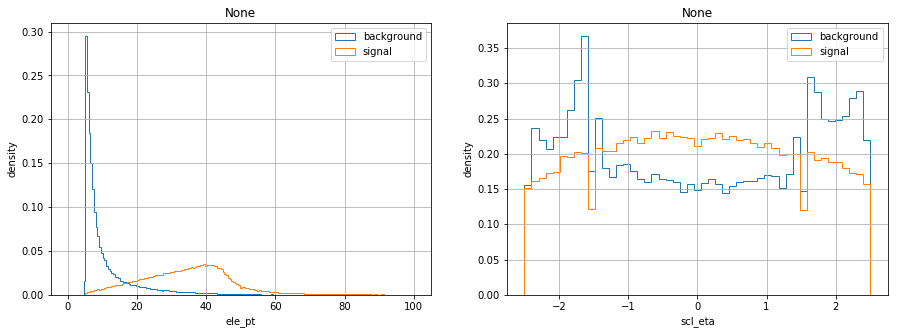

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_electrons(df, "ele_pt", np.linspace(0, 100, 200), ax=axes[0])
plot_electrons(df, "scl_eta", np.linspace(-2.5, 2.5, 50), ax=axes[1])
plt.show()

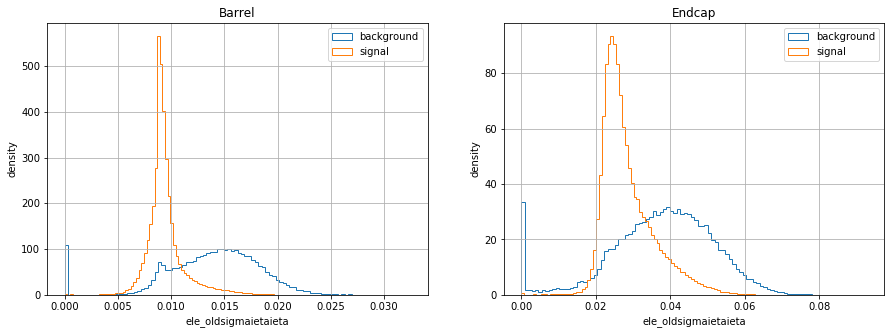

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_electrons(df.query("ele_isEB"), "ele_oldsigmaietaieta", 100, ax=axes[0], title="Barrel")
plot_electrons(df.query("ele_isEE"), "ele_oldsigmaietaieta", 100, ax=axes[1], title="Endcap")
plt.show()

## Training the Boosted Decision Tree Classifiers

In [16]:
features = ["ele_oldsigmaietaieta", "ele_oldsigmaiphiiphi",
            "ele_oldcircularity", "ele_oldr9", "ele_scletawidth",
            "ele_sclphiwidth", "ele_oldhe", "ele_kfhits", "ele_kfchi2",
            "ele_gsfchi2", "ele_fbrem", "ele_gsfhits",
            "ele_expected_inner_hits", "ele_conversionVertexFitProbability",
            "ele_ep", "ele_eelepout", "ele_IoEmIop", "ele_deltaetain",
            "ele_deltaphiin", "ele_deltaetaseed", "rho",
            "ele_pfPhotonIso", "ele_pfChargedHadIso", "ele_pfNeutralHadIso",
            "ele_psEoverEraw"]

In [17]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [18]:
import xgboost2tmva

In [19]:
def train_test_split_return_indices(X, y, test_size=None, random_state=None):
    
    # create array with indices
    if hasattr(y, "index"):
        indices = y.index.values
        y = y.values
    else:
        indices = np.arange(len(y))
    
    # store original shape of y
    y_shape = y.shape[1:]
    
    # reshape y so we can piggy-back the indices with it
    y = y.reshape((len(y),-1))
    
    # add the indices to y
    y = np.concatenate([y, indices.reshape((-1,1))], axis=1)
    
    # do the actual test-train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # extract the indices for the train and test set
    idx_train = np.array(y_train[:,-1], dtype=np.int)
    idx_test = np.array(y_test[:,-1], dtype=np.int)

    # extract the actual y_train and y_test
    y_train = y_train[:,:-1].reshape((y_train.shape[0],) + y_shape)
    y_test = y_test[:,:-1].reshape((y_test.shape[0],) + y_shape)

    return X_train, X_test, y_train, y_test, idx_train, idx_test

In [20]:
xgboost_params = {'eval_metric':'auc',
              'objective'  :'binary:logitraw',
              'max_depth' : 3,
              'min_child_weight' : 10,
              'gamma' : 0.5,
              'alpha' : 1., 
             }

In [22]:
for i, group_df in df.groupby("EleMVACats"):
    
    X = group_df[features]
    y = group_df["matchedToGenEle"]

    res = train_test_split_return_indices(X, y, test_size=0.33, random_state=42)
    X_train, X_test, y_train, y_test, idx_train, idx_test = res
    
    print("training for category " + str(i) + " on " + str(len(y_train)) + " events...")

    dmatrix_train = xgb.DMatrix(X_train.copy(), label=np.copy(y_train))
    dmatrix_test  = xgb.DMatrix(X_test.copy(), label=np.copy(y_test ))

    model = xgb.train(xgboost_params, dmatrix_train, num_boost_round=10,
                      evals= [(dmatrix_train, 'train'),
                               (dmatrix_test, 'test')],
                      early_stopping_rounds=10,
                      verbose_eval=False)
    
    xgboost2tmva.convert_model(model.get_dump(),
                               input_variables=[(f,'F') for f in features],
                               output_xml='electron_id_{0}.xml'.format(i))
    
    model.save_model("electron_id_{0}.bin".format(i))
    
    df.loc[idx_test, "score"] = model.predict(dmatrix_test)

training for category 0 on 12909 events...
training for category 1 on 12354 events...
training for category 2 on 25456 events...
training for category 3 on 66425 events...
training for category 4 on 54694 events...
training for category 5 on 71857 events...


In [23]:
df_test = df.dropna()

In [24]:
from sklearn import metrics

def plot_roc_curve(df, score_column, tpr_threshold=0.7, ax=None):
    if ax is None:
        ax = plt.gca()
    fpr, tpr, thresholds = metrics.roc_curve(df["matchedToGenEle"], df[score_column])
    mask = tpr > tpr_threshold
    fpr, tpr = fpr[mask], tpr[mask]
    ax.semilogy(tpr, fpr, label=score_column)

In [25]:
category_titles = ["EB1_5", "EB2_5", "EE_5", "EB1_10", "EB2_10", "EE_10"]

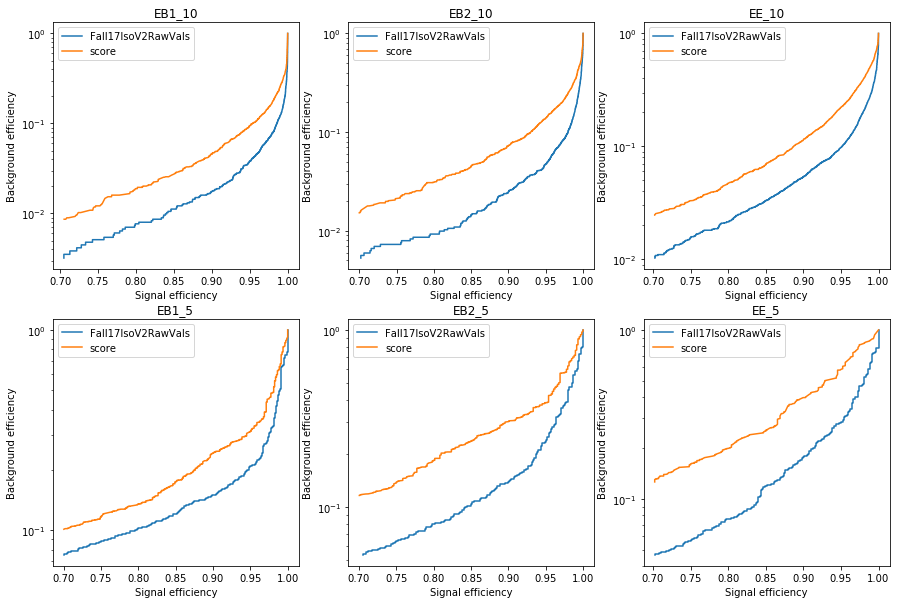

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, group_df in df_test.groupby("EleMVACats"):
    
    
    ax = axes[int(i < 3),i%3]
    plot_roc_curve(group_df, "Fall17IsoV2RawVals", ax=ax)
    plot_roc_curve(group_df, "score", ax=ax)
    ax.set_title(category_titles[i])
    ax.legend()
    ax.set_xlabel("Signal efficiency")
    ax.set_ylabel("Background efficiency")
    
plt.show()